In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
import gc

# custom module for capstone 2
import cap2tools as c2t

In [2]:
def run_in_replicate(width, n_models=2, n_epochs=10, new_weights=False, trainable=False, 
                     learning_rate=0.0001, dropout1=0, dropout2=0):
    '''
    Runs two initialization and training passes for each model variation
    
    Returns the training history
    '''
    from datetime import datetime
    from keras.callbacks import ModelCheckpoint
    
    filename = 'vgg16_dropout1_{}_'.format(str(dropout1).replace('.', '-'))
    
    histories = []
    
    for idx in range(1, n_models+1):
        datetime_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        print('{} - Starting training for {}'.format(datetime_now, filename + str(idx)))

        # define callback for model saving
        checkpointer = ModelCheckpoint(filename + str(idx) + '.h5', 
                                       monitor='val_loss', 
                                       verbose=0, 
                                       save_best_only=True)

        # build and train model
        model = c2t.build_VGG16(width, new_weights=new_weights, trainable=trainable, 
                                learning_rate=learning_rate, dropout1=dropout1, 
                                dropout2=dropout2)
        hist = model.fit_generator(train_batches,
                                   validation_data=valid_batches,
                                   epochs=n_epochs, 
                                   callbacks=[checkpointer], 
                                   verbose=0)
        histories.append(hist)
        
        # remove clutter from memory
        del model
        K.clear_session()
        
    def avg_metric(metric):
        average_metric = np.array(histories[0].history[metric])
        
        for idx in range(1, len(histories)):
            average_metric += np.array(histories[idx].history[metric])
            
        return average_metric/len(histories)
    
    # determine average metrics of the two runs
    acc = avg_metric('acc')
    loss = avg_metric('loss')
    val_acc = avg_metric('val_acc')
    val_loss = avg_metric('val_loss')
    
    # plot loss history
    plot_df = tuple([loss, val_loss])
    plot_df = np.column_stack(plot_df)
    plot_df = pd.DataFrame(plot_df, columns=('training', 'validation'))
    
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_df.plot(ax=ax)
    plt.title('Loss over epochs: {}'.format(filename))
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.xticks(range(0, len(loss)))
    plt.legend(loc='upper right')
    plt.show()
    
    return {'acc': acc, 'loss':loss, 'val_acc':val_acc, 'val_loss':val_loss}

In [3]:
# configure GPU memory usage by tensorflow
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
K.tensorflow_backend.set_session(K.tf.Session(config=config))

In [4]:
# define paths to image directories
train_path = 'sampled_photos/train'
valid_path = 'sampled_photos/val'

# build image generators to feed CNN
train_batches, valid_batches = c2t.build_data_gens([train_path, valid_path])

Found 9000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


2018-09-01 01:48:32 - Starting training for vgg16_dropout1_0_1
2018-09-01 02:30:38 - Starting training for vgg16_dropout1_0_2


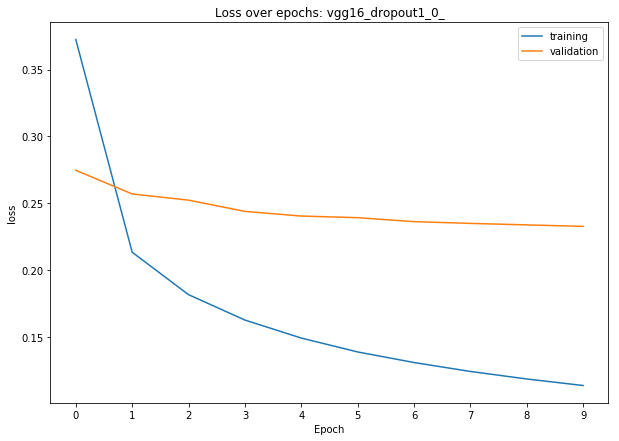

2018-09-01 03:11:40 - Starting training for vgg16_dropout1_0-1_1
2018-09-01 03:52:29 - Starting training for vgg16_dropout1_0-1_2


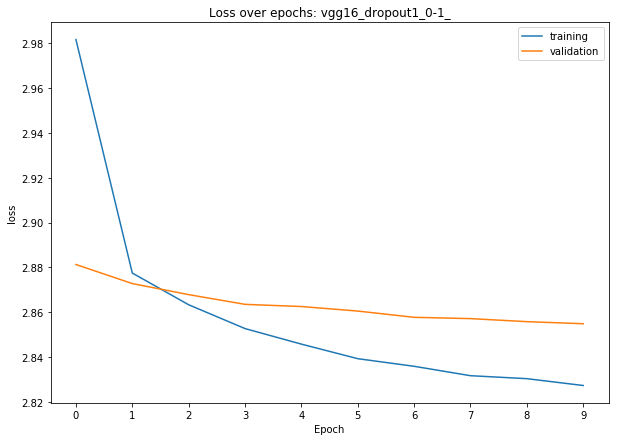

2018-09-01 04:33:35 - Starting training for vgg16_dropout1_0-2_1
2018-09-01 05:14:24 - Starting training for vgg16_dropout1_0-2_2


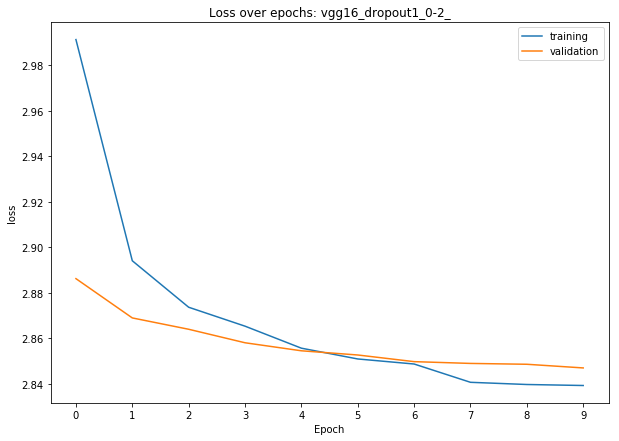

2018-09-01 05:55:30 - Starting training for vgg16_dropout1_0-3_1
2018-09-01 06:36:35 - Starting training for vgg16_dropout1_0-3_2


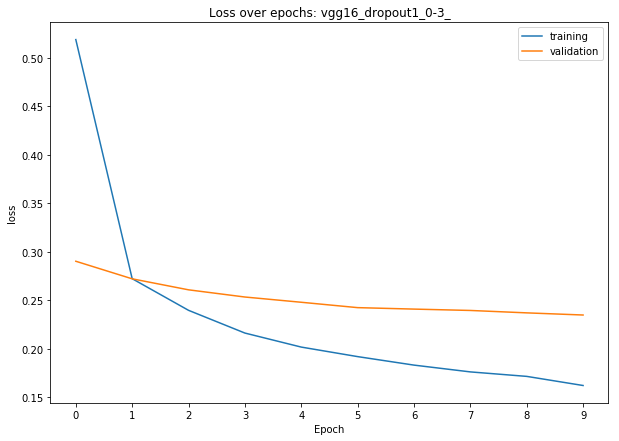

2018-09-01 07:17:40 - Starting training for vgg16_dropout1_0-4_1
2018-09-01 07:58:44 - Starting training for vgg16_dropout1_0-4_2


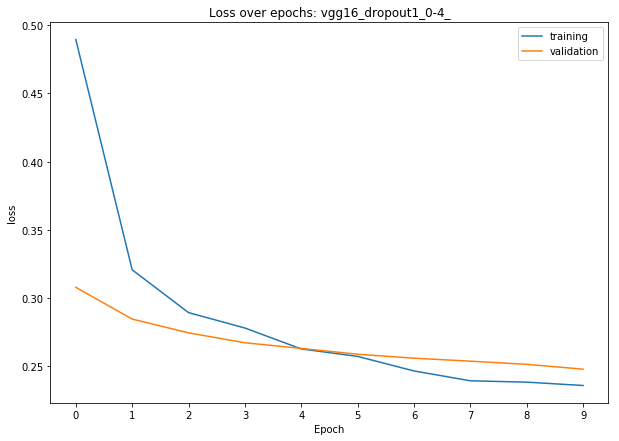

2018-09-01 08:39:50 - Starting training for vgg16_dropout1_0-5_1
2018-09-01 09:20:56 - Starting training for vgg16_dropout1_0-5_2


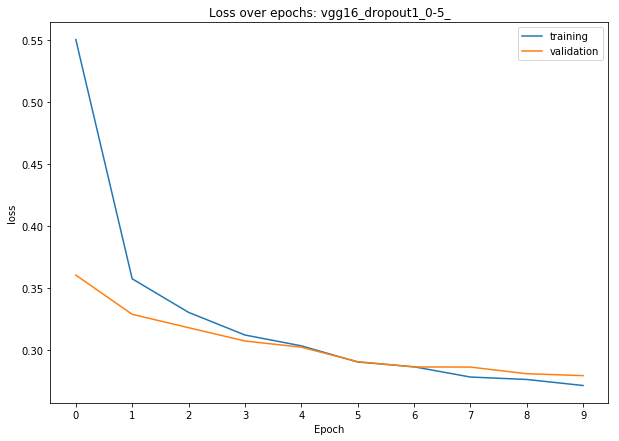

2018-09-01 10:02:01 - Starting training for vgg16_dropout1_0-6_1
2018-09-01 10:42:53 - Starting training for vgg16_dropout1_0-6_2


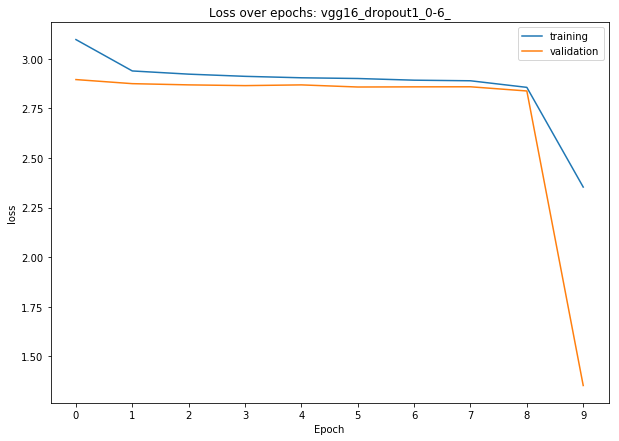

2018-09-01 11:23:53 - Starting training for vgg16_dropout1_0-7_1
2018-09-01 12:04:43 - Starting training for vgg16_dropout1_0-7_2


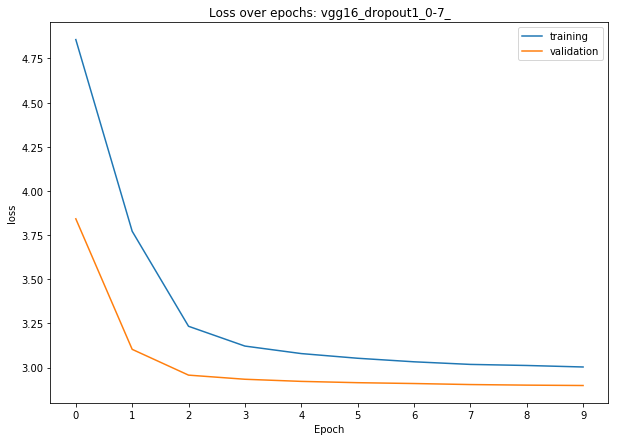

2018-09-01 12:45:50 - Starting training for vgg16_dropout1_0-8_1
2018-09-01 13:26:58 - Starting training for vgg16_dropout1_0-8_2


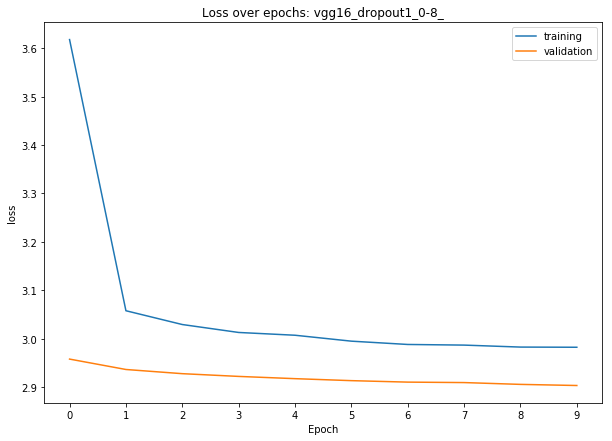

In [5]:
# test different conditions for model
d1s = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

histories = dict()

for d1 in d1s:
    histories[d1] = run_in_replicate(width=800, 
                                     n_models=2,
                                     n_epochs=10, 
                                     new_weights=False, 
                                     trainable=True,
                                     dropout1=d1)

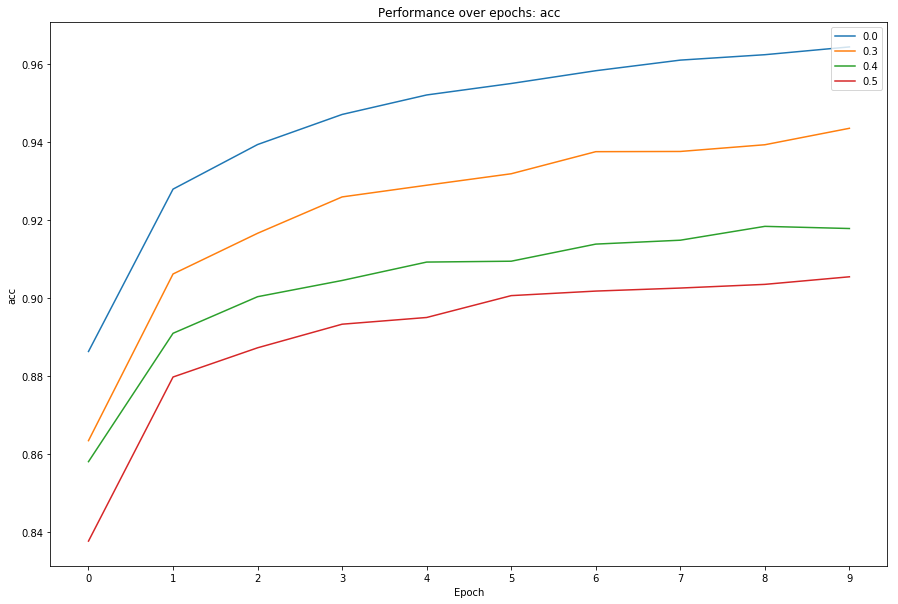

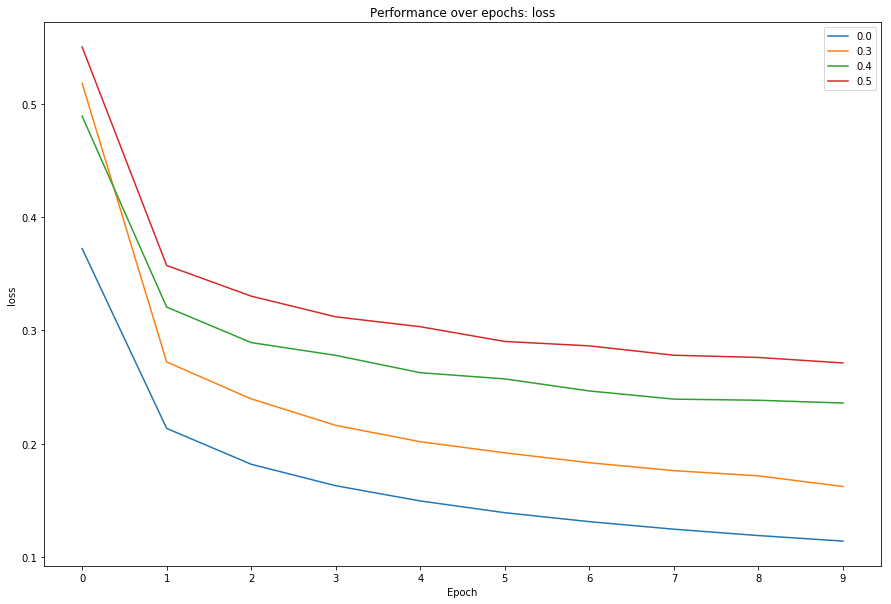

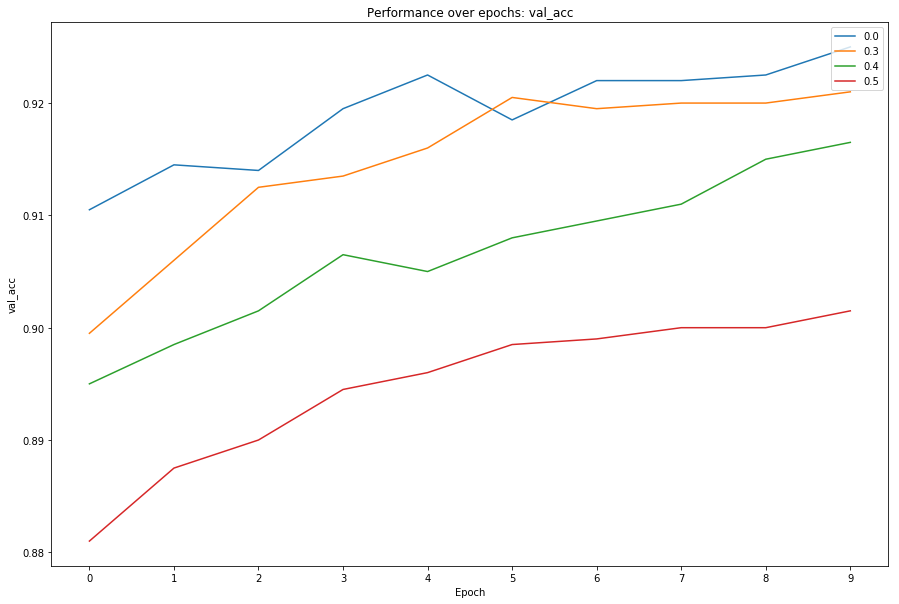

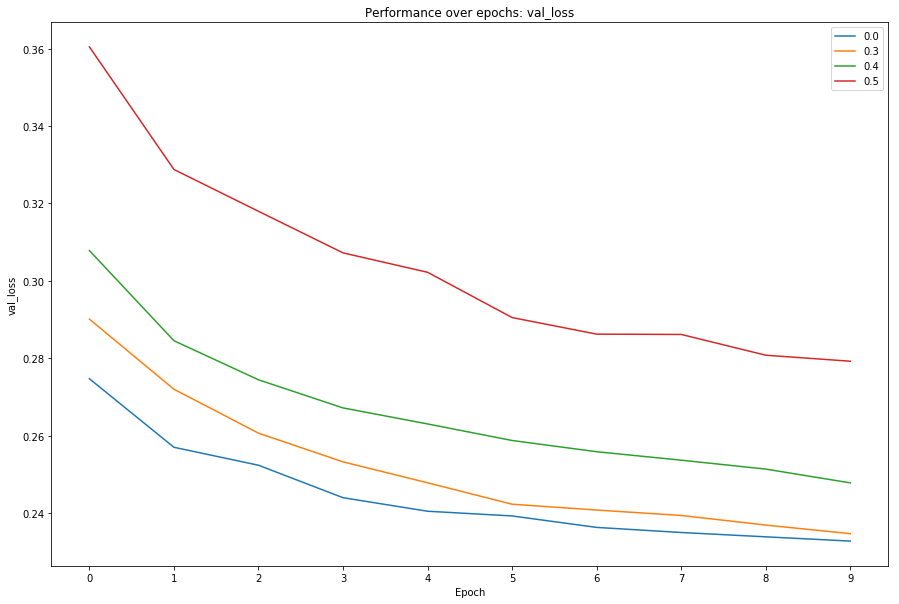

In [12]:
# save history as json
hist_path = 'VGG16_dropout_comparison_history.json'
pd.DataFrame(histories).transpose().to_json(hist_path)

# load history from json
histories_load = pd.read_json(hist_path, convert_axes=False)

# drop conditions with poor performance
histories_load.drop(['0.1', '0.2', '0.6', '0.7', '0.8'], inplace=True)

def plot_metric(metric, histories):
    '''
    Plots one metric from dataframe of histories, for comparison of different
    models
    
    Parameters:
    metric(string) - the metric to be plotted
    histories(DataFrame) - CNN training history across epochs for different 
        models
        
    '''
    
    # extract metric of interest
    metric_df = pd.DataFrame()
    for i, history in histories.iterrows():
        metric_df[i] = history[metric]

    # plot history
    fig, ax = plt.subplots(figsize=(15, 10))
    metric_df.plot(ax=ax)
    plt.title('Performance over epochs: {}'.format(metric))
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.xticks(range(0, len(metric_df.iloc[:, 1])))
    plt.legend(loc='upper right')
    plt.show()

# plot history comparisons
plot_metric('acc', histories_load)
plot_metric('loss', histories_load)
plot_metric('val_acc', histories_load)
plot_metric('val_loss', histories_load)

In [13]:
# evaluate trained models on validation dataset
data_path = 'sampled_photos/val'

model_paths = {'0':'vgg16_dropout1_0_1.h5', 
               '0.1':'vgg16_dropout1_0-1_1.h5', 
               '0.2':'vgg16_dropout1_0-2_1.h5', 
               '0.3':'vgg16_dropout1_0-3_1.h5', 
               '0.4':'vgg16_dropout1_0-4_1.h5', 
               '0.5':'vgg16_dropout1_0-5_1.h5', 
               '0.6':'vgg16_dropout1_0-6_1.h5', 
               '0.7':'vgg16_dropout1_0-7_1.h5', 
               '0.8':'vgg16_dropout1_0-8_1.h5'}

model_metrics = c2t.eval_models(model_paths, data_path)

# create table of evaluation results
table = c2t.eval_table(model_metrics, 'Dropout1', decimals=3)
table

Building image generator...
Found 1000 images belonging to 5 classes.
Loading model vgg16_dropout1_0_1.h5
Evaluating model vgg16_dropout1_0_1.h5
Loading model vgg16_dropout1_0-1_1.h5
Evaluating model vgg16_dropout1_0-1_1.h5
Loading model vgg16_dropout1_0-2_1.h5
Evaluating model vgg16_dropout1_0-2_1.h5
Loading model vgg16_dropout1_0-3_1.h5
Evaluating model vgg16_dropout1_0-3_1.h5
Loading model vgg16_dropout1_0-4_1.h5
Evaluating model vgg16_dropout1_0-4_1.h5
Loading model vgg16_dropout1_0-5_1.h5
Evaluating model vgg16_dropout1_0-5_1.h5
Loading model vgg16_dropout1_0-6_1.h5
Evaluating model vgg16_dropout1_0-6_1.h5
Loading model vgg16_dropout1_0-7_1.h5
Evaluating model vgg16_dropout1_0-7_1.h5
Loading model vgg16_dropout1_0-8_1.h5
Evaluating model vgg16_dropout1_0-8_1.h5
Evaluation complete.



,acc,loss,mpcr
Dropout 1,,,
0,0.919,0.255,0.615
0.1,0.662,5.448,0.200
0.2,0.662,5.448,0.200
0.3,0.918,0.241,0.668
0.4,0.914,0.256,0.589
0.5,0.896,0.297,0.482
0.6,0.716,2.449,0.252
0.7,0.662,5.448,0.200
0.8,0.861,0.358,0.393


In [14]:
# run garbage collection after execution
gc.collect()

141612

In [15]:
model_metrics

{'0': {'loss': 0.25456377294746924,
  'acc': 0.919,
  'cm': [[15, 7, 6, 0, 1],
   [7, 648, 4, 0, 3],
   [1, 9, 198, 0, 13],
   [0, 0, 2, 0, 1],
   [0, 2, 25, 0, 58]],
  'mpcr': 0.6148747772085988},
 '0.1': {'loss': 5.447916322708139,
  'acc': 0.662,
  'cm': [[0, 29, 0, 0, 0],
   [0, 662, 0, 0, 0],
   [0, 221, 0, 0, 0],
   [0, 3, 0, 0, 0],
   [0, 85, 0, 0, 0]],
  'mpcr': 0.2},
 '0.2': {'loss': 5.447916322708139,
  'acc': 0.662,
  'cm': [[0, 29, 0, 0, 0],
   [0, 662, 0, 0, 0],
   [0, 221, 0, 0, 0],
   [0, 3, 0, 0, 0],
   [0, 85, 0, 0, 0]],
  'mpcr': 0.2},
 '0.3': {'loss': 0.2410899419981579,
  'acc': 0.918,
  'cm': [[14, 7, 8, 0, 0],
   [1, 657, 4, 0, 0],
   [1, 16, 188, 0, 16],
   [0, 0, 0, 1, 2],
   [0, 2, 25, 0, 58]],
  'mpcr': 0.6683141516280997},
 '0.4': {'loss': 0.25638880139187675,
  'acc': 0.914,
  'cm': [[14, 8, 7, 0, 0],
   [3, 654, 4, 0, 1],
   [3, 14, 196, 0, 8],
   [0, 0, 2, 0, 1],
   [1, 4, 30, 0, 50]],
  'mpcr': 0.5891574301433171},
 '0.5': {'loss': 0.2968660353398882,
  '